In [3]:
import os
print(os.getcwd())


c:\Users\carpe\OneDrive\Desktop\workspace\project\Aution\Auction\models


In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# 데이터 경로 설정
base_dir = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
data_dir = os.path.join(base_dir, 'data')
file_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'daily_average_price_volume_by_product_seoul.csv')

# 모델 저장 경로
saved_model_dir = os.path.join(base_dir, 'saved_models')
os.makedirs(saved_model_dir, exist_ok=True)

# 데이터 로드
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Data file not found at {file_path}")
data = pd.read_csv(file_path)

# 데이터 정렬
data['일자'] = pd.to_datetime(data['일자'])
data = data.sort_values(['품목', '일자'])

# 계절 원핫인코딩
onehot_encoder = OneHotEncoder(sparse_output=False)
seasons_encoded = onehot_encoder.fit_transform(data[['계절']])
season_columns = onehot_encoder.get_feature_names_out(['계절'])
season_df = pd.DataFrame(seasons_encoded, columns=season_columns)

# 원핫인코딩된 계절 추가
data = pd.concat([data.reset_index(drop=True), season_df.reset_index(drop=True)], axis=1)

# 성능 결과 저장용 리스트
performance_results = []

# 각 품목별로 처리
def preprocess_and_train(grouped_data, product_name):
    # 필요한 컬럼 선택 
    feature_columns = ['총물량', '평균단가', '온도차(°C)', '평균기온(°C)', '일강수량(mm)'] + list(season_columns)
    data_subset = grouped_data[feature_columns]

    # 스케일링
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_subset)
    
    # 시계열 데이터 생성
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length, :])
            y.append(data[i+seq_length, 1])  # 평균단가 예측
        return np.array(X), np.array(y)

    sequence_length = 30
    X, y = create_sequences(scaled_data, sequence_length)

    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 1
    final_y_test, final_y_pred = None, None  # 마지막 fold 결과 저장
    for train_index, test_index in tscv.split(X):
        print(f"Processing fold {fold} for product: {product_name}")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 모델 구성
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
            LSTM(50, return_sequences=False),
            Dense(25, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')

        # 체크포인트 설정
        checkpoint_path = os.path.join(saved_model_dir, f'{product_name}_fold{fold}_model.keras')
        checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

        # 모델 훈련
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[checkpoint])

        # 성능 평가
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        performance_results.append({"product": product_name, "fold": fold, "mse": mse})
        print(f"Performance for {product_name}, fold {fold}: MSE = {mse}")
        print(f"Model for {product_name}, fold {fold} saved at {checkpoint_path}")

        # 마지막 fold 결과 저장
        if fold == 5:
            final_y_test = y_test
            final_y_pred = y_pred

        fold += 1

    # 마지막 fold의 결과를 반환
    return final_y_test, final_y_pred

# 특정 품목만 선택
specific_product = "배추"
grouped = data.groupby('품목')

y_test, y_pred = None, None
for product, group in grouped:
    if product == specific_product:  # 특정 품목만 처리
        print(f"Processing product: {product}")
        y_test, y_pred = preprocess_and_train(group, product)

# 마지막 fold의 결과 저장
if y_test is not None and y_pred is not None:
    results_df = pd.DataFrame({"y_test": y_test.flatten(), "y_pred": y_pred.flatten()})
    results_path = os.path.join(saved_model_dir, 'lstm_results_baechu.csv')
    results_df.to_csv(results_path, index=False)
    print(f"Final fold results saved to {results_path}")

# 성능 결과 저장
performance_df = pd.DataFrame(performance_results)
performance_csv_path = os.path.join(saved_model_dir, 'performance_results.csv')
performance_df.to_csv(performance_csv_path, index=False)
print(f"Performance results saved to {performance_csv_path}")


Processing product: 배추
Processing fold 1 for product: 배추


c:\Users\carpe\Anaconda3\envs\cv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - loss: 0.0555 - val_loss: 0.0214
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0100 - val_loss: 0.0276
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0104 - val_loss: 0.0216
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0069 - val_loss: 0.0195
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0086 - val_loss: 0.0199
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0055 - val_loss: 0.0173
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0066 - val_loss: 0.0155
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0057 - val_loss: 0.0145
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0051 - val_loss: 0.0136
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0047 - val_loss: 0.0134
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0058 - val_loss: 0.0158
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.

c:\Users\carpe\Anaconda3\envs\cv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - loss: 0.0250 - val_loss: 0.0113
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0090 - val_loss: 0.0096
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0080 - val_loss: 0.0063
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0062 - val_loss: 0.0071
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0049 - val_loss: 0.0061
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0054 - val_loss: 0.0067
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0052 - val_loss: 0.0067
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0049 - val_loss: 0.0076
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0

c:\Users\carpe\Anaconda3\envs\cv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - loss: 0.0180 - val_loss: 0.0126
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0065 - val_loss: 0.0076
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0057 - val_loss: 0.0078
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0046 - val_loss: 0.0076
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0054 - val_loss: 0.0062
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0

c:\Users\carpe\Anaconda3\envs\cv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - loss: 0.0177 - val_loss: 0.0077
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0083 - val_loss: 0.0076
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0052 - val_loss: 0.0063
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0059 - val_loss: 0.0064
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0051 - val_loss: 0.0065
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - los

c:\Users\carpe\Anaconda3\envs\cv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - loss: 0.0322 - val_loss: 0.0085
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0062 - val_loss: 0.0047
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 

Performance for 배추, fold 1: MSE = 0.010481850667641237
Performance for 배추, fold 2: MSE = 0.005459886127959179
Performance for 배추, fold 3: MSE = 0.005194442262723341
Performance for 배추, fold 4: MSE = 0.006096574019933123
Performance for 배추, fold 5: MSE = 0.004025961656965828

c:\Users\carpe\Anaconda3\envs\cv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\carpe\Anaconda3\envs\cv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


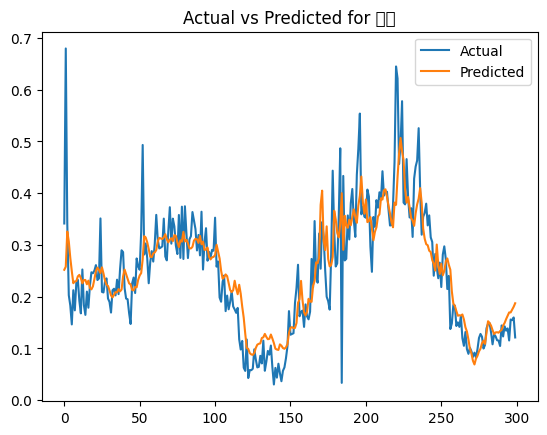

In [8]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted for 배추')
plt.show()

In [ ]:
import shutil

# 저장된 모델 삭제
shutil.rmtree(saved_model_dir)
os.makedirs(saved_model_dir, exist_ok=True)
